## Time to get your hands dirty! Supernova distances and redshifts (part 2)
First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

In [1]:
from astroML.datasets import generate_mu_z
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
from scipy.integrate import quad
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
from astropy import constants as const
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import train_test_split
import emcee
import corner
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

Created function to compute theorical $\mu$

In [2]:
d = (10*u.pc).to(u.Mpc).value
print(const.c)
def mu_func(z_s, H_0, Om_m):
    y = []
    for zeta in z_s:
        integral = quad(lambda x: np.sqrt(Om_m*(1+x)**3+0.7)**(-1), 0, zeta)[0]
        y.append(5*np.log10((const.c.to(u.km/u.s).value/H_0)/d*(1+zeta)*integral))
    return np.array(y)

  Name   = Speed of light in vacuum
  Value  = 299792458.0
  Uncertainty  = 0.0
  Unit  = m / s
  Reference = CODATA 2018


Created sampling and plotted it with the theorical trend

(0.0, 2.0)

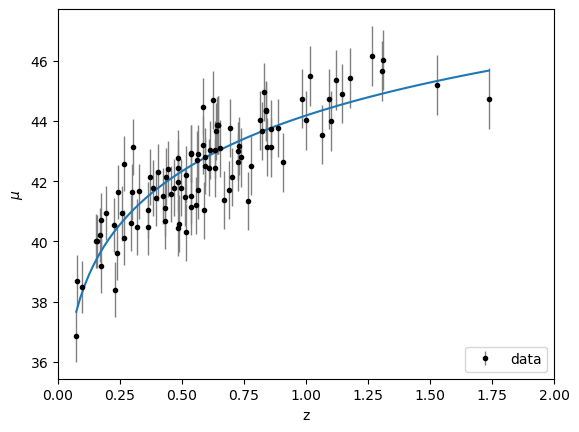

In [3]:
n = 100
z_sample, mu_sample, dmu = generate_mu_z(n, random_state=1234)
z_lin = np.linspace(min(z_sample), max(z_sample), n)

#print(result)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z_lin, mu_func(z_lin,  cosmo.H(0).value, 0.27))
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
#plt.ylim(35,50);

### 1. Curve-Fit

Firstly, I used curve_fit in order to obtain the best parameters for my fit. 

In [4]:
#avoiding maximum likelihood because I don't know how to do it with four parameters
my_guesses = [ cosmo.H(0).value, 0.27]
parameters, covariance = curve_fit(mu_func, z_sample, mu_sample, p0 = my_guesses)
print('Curve fit guess for H0: ', parameters[0])
print('Curve fit guess for Omega Matter: ', parameters[1])
print('Covariance for the 2 parameters:\n', covariance)

Curve fit guess for H0:  71.50473869305307
Curve fit guess for Omega Matter:  0.268569596482695
Covariance for the 2 parameters:
 [[ 3.72524793e+02 -6.24405757e+00]
 [-6.24405757e+00  1.07298349e-01]]


Real parameters:      H0 = 69.320, Omega Matter = 0.270
Curve fit parameters: H0 = 71.505, Omega Matter = 0.269


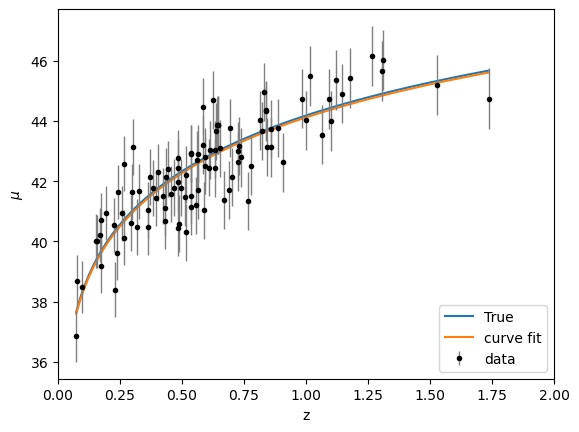

In [5]:
plt.plot(z_lin, mu_func(z_lin,  cosmo.H(0).value, 0.27), label = 'True')
plt.plot(z_lin, mu_func(z_lin,  parameters[0], parameters[1]), label = 'curve fit')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)

print('Real parameters:      H0 = %.3f, Omega Matter = %.3f' %(cosmo.H(0).value, 0.27))
print('Curve fit parameters: H0 = %.3f, Omega Matter = %.3f' %(parameters[0], parameters[1]))

### 2. Gaussian Process Regressor

Then, instead of using the generating function, I tried to fit the data with a gaussian process.

In [6]:
z_train, z_test, mu_train, mu_test = train_test_split(z_sample[:, None], mu_sample, test_size=0.3, shuffle=False)

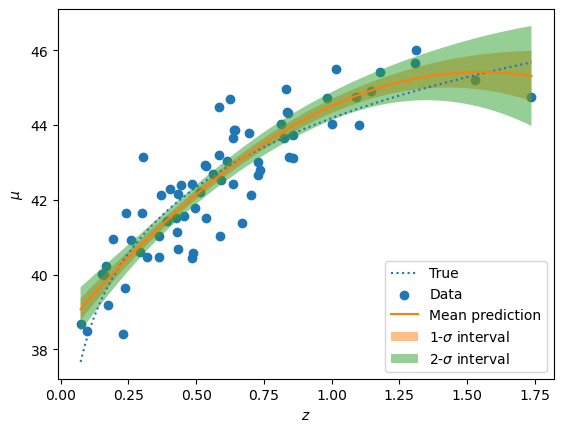

In [7]:
kernel = ConstantKernel()* RBF()
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha = dmu[:70]**2)
gaussian_process.fit(z_train, mu_train)
gaussian_process.kernel_
mean_prediction, std_prediction = gaussian_process.predict(z_lin[:, None], return_std=True)
plt.plot(z_lin[:, None], mu_func(z_lin[:, None], cosmo.H(0).value, 0.27), label=r"True", linestyle="dotted")
plt.scatter(z_train, mu_train, label="Data")
plt.plot(z_lin[:, None], mean_prediction, label="Mean prediction")
plt.fill_between(
    z_lin.ravel(),
    mean_prediction - std_prediction,
    mean_prediction +std_prediction,
    alpha=0.5,
    label=r"1-$\sigma$ interval",
)
plt.fill_between(
    z_lin.ravel(),
    mean_prediction - 2*std_prediction,
    mean_prediction +2*std_prediction,
    alpha=0.5,
    label=r"2-$\sigma$ interval",
)
plt.legend()
plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.show()

### 3. MCMC 

Another way to estimate the parameters for the theorical function is to use MCMC

In [8]:
#limits of each parameter, suggested by exercise
H_min, H_max = 30.0, 100.0
omegam_min, omegam_max = 0.1, 1.0

def mu_func_emcee(theta, z):
    H_0, Om_m = theta
    y = []
    for t in z:
        integral = quad(lambda x: np.sqrt(Om_m*(1+x)**3+0.7)**(-1), 0, t)[0]
        y.append(5*np.log10((const.c.to(u.km/u.s).value/H_0)/d*(1+t)*integral))
    return y

#log-prior as described by emcee
def log_prior(theta):
    H, omega = theta
    if H_min < H < H_max and omegam_min < omega < omegam_max:
        return 0.0 +0.0
    return -np.inf

#log likelihood as described by emcee
def log_likelihood(theta, x, y, err):
    H, omega = theta
    #alpha= exp logalpha
    model = mu_func_emcee(theta, x)
    #sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)   ask professor, now I just use yerr
    return -0.5 * np.sum((y - model) ** 2 / err**2 + np.log(err**2))

#log probability as described by emcee
def log_probability(theta, x, y, err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return - np.inf
    return lp + log_likelihood(theta, x, y, err)

In [9]:
nwalkers, ndim = 7, 2 #number of walkers and dimensions
burn, nsteps = 100, 10000 #step needed to burn, and total number of steps

np.random.seed(9)
starting_guesses = parameters + np.random.random((nwalkers, ndim)) #walkers starting from good points, otherwise error
#initializing emcee
sampler_mcmc = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(z_sample, mu_sample, dmu))
sampler_mcmc.run_mcmc(starting_guesses, nsteps, progress = True)
emcee_trace = sampler_mcmc.chain[:, burn:, :].reshape(-1, ndim) #getting emcee_trace

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\hp\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 16%|████████████                                                                 | 1571/10000 [01:58<09:38, 14.56it/s]Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\Lib\site-packages\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hp\AppData\Local\Temp\ipykernel_14440\2050245012.py", line 33, in log_probability
    return lp + log_likelihood(theta, x, y, err)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hp\AppData\Local\Temp\ipykernel_14440\2050245012.py", line 24, in log_likelihood
    model = mu_func_emcee(theta, x)
            ^^^^^^^^^^^^^^^^^^^^^^^
  Fil

emcee: Exception while calling your likelihood function:
  params: [84.53868475  0.14850634]
  args: (array([0.29907871, 0.64057897, 0.48439381, 0.83200371, 0.82408678,
       0.36113938, 0.36402348, 0.8573685 , 1.30588524, 0.99995019,
       0.42423046, 0.53429221, 0.70331746, 0.73642792, 0.43346403,
       0.58487846, 0.5359888 , 0.09800896, 0.81381534, 1.01633991,
       0.42947624, 0.63416305, 0.1935354 , 0.43240289, 1.17731844,
       0.66951722, 0.45360888, 0.8370468 , 0.39392919, 0.59093132,
       0.98410959, 0.48319916, 0.8578064 , 0.25959377, 0.72661499,
       0.72698343, 0.32043128, 1.14459622, 0.48779261, 1.09114495,
       0.17527352, 0.29329624, 0.15899309, 0.69403869, 0.61477425,
       0.56098838, 0.1532864 , 0.58508523, 0.40340699, 0.53589418,
       0.23081645, 0.62642515, 0.58903611, 0.07571118, 0.63611004,
       1.10014003, 0.83975753, 1.7374507 , 1.31019458, 0.84194741,
       0.37055496, 0.64328593, 0.51591245, 0.3023762 , 0.44245798,
       0.16774019, 0.495151

KeyboardInterrupt: 

In [ ]:
#check that number of steps are enough higher than the needed burning steps
tau = max(sampler_mcmc.get_autocorr_time())
print(tau)
thin = int(tau+1)

In [ ]:
emcee_trace = sampler_mcmc.get_chain(discard = burn, thin = thin, flat = True).flatten()
len(emcee_trace)

In [ ]:
#plot trace as shown by emcee
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_mcmc = sampler_mcmc.get_chain()
labels = ["H0", r"$\Omega_m$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_mcmc[:, :, i], "k", alpha=0.3)
    ax.axhline(parameters[i], color = 'orange') #add line with initial guesses
    ax.set_xlim(0, len(samples_mcmc))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

In [ ]:
#plotting corner plot as shown by emcee
flat_samples_mcmc = sampler_mcmc.get_chain(discard=100, thin=15, flat=True)
print(flat_samples_mcmc.shape)

In [ ]:
corner.corner(sampler_mcmc.get_chain(discard = burn, thin = thin, flat = True), 
              labels = labels, truths=parameters,levels=[0.68, 0.95], 
              quantiles=[0.16, 0.5, 0.84],show_titles=True,
    title_kwargs={"fontsize": 12}); #ask how to avoid overlap of numbers/label

### 4. Nested Sampling

Here, I use nested sampling to derive the parameters of the generating function.

In [ ]:
ndim = 2
#limits of each parameter, suggested by exercise
H_min, H_max = 30.0, 100.0
omegam_min, omegam_max = 0.1, 1.0


#log likelihood as described by emcee
def log_likelihood(theta):
    H_0, omega = theta
    #alpha= exp logalpha
    #model = burst(theta)
    model = mu_func_emcee(theta, z_sample)
    return -0.5 * np.sum((mu_sample - model) ** 2 / dmu**2)

# Define our uniform prior via the prior transform.
def prior_transform(u):
    uH, uomega = u
    H = H_min + uH  *(H_max-H_min)
    omega = omegam_min + uomega*(omegam_max-omegam_min)
    return H, omega

dsampler = dynesty.NestedSampler(log_likelihood, prior_transform, ndim,nlive=5000)
dsampler.run_nested()
dresults = dsampler.results

In [ ]:
fig, axes = dyplot.runplot(dresults)

In [ ]:
samples_nested = dresults.samples  # samples
weights_nested = np.exp(dresults.logwt - dresults.logz[-1])  # normalized weights

samples_equal_nested = dyfunc.resample_equal(samples_nested, weights_nested)
corner.corner(samples_equal_nested,labels=labels, truths = parameters,levels=[0.68, 0.95], 
              quantiles=[0.16, 0.5, 0.84],show_titles=True,
    title_kwargs={"fontsize": 12});

### 5. Results Comparison

Comparing the results obtained from each method, we can say that curve_fit was able to get closer to the correct values, followed by MCMC and then nested sampling.

In [ ]:
print('---------- VALUES FOR H0 -------------')
print('Curve fit guess for H0: %.3f' %parameters[0])
print('MCMC guess for H0: %.3f' %np.median(sampler_mcmc.get_chain(discard=burn, thin=thin,flat = True)[:, 0]))
print('Nested Sampling guess for H0: %.3f' %[dyfunc.quantile(samps, [0.5], weights=weights_nested)
             for samps in samples_nested.T][0][0])
print('Real value for H0: %.3f \n' % cosmo.H(0).value)

print('---------- VALUES FOR OMEGA MATTER ----------')
print('Curve fit guess for Omega Matter: %.3f' %parameters[1])
print('MCMC guess for Omega Matter: %.3f' %np.median(sampler_mcmc.get_chain(discard=burn, thin=thin,flat = True)[:, 1]))
print('Nested Sampling guess for Omega Matter: %.3f' %[dyfunc.quantile(samps, [0.5], weights=weights_nested)
             for samps in samples_nested.T][1][0])
print('Real value for Omega Matter: %.3f' % 0.27)

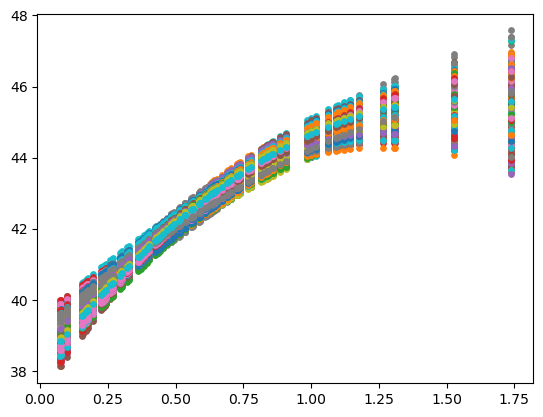

In [34]:
sample = gaussian_process.sample_y(z_sample[:, None], n_samples=1000)
    #sample.shape()
for i in range(1000):
    plt.scatter(z_sample[:, None], sample[:, i], s = 15)


(array([[ 2.,  7., 12., ...,  1.,  0.,  0.],
        [ 0.,  9., 12., ...,  5.,  2.,  0.],
        [ 3.,  6., 12., ..., 11.,  0.,  0.],
        ...,
        [ 0.,  5., 14., ...,  5.,  1.,  0.],
        [ 2.,  7., 11., ..., 13.,  0.,  0.],
        [ 3.,  6., 12., ..., 11.,  0.,  0.]]),
 array([38.13128392, 39.07596188, 40.02063984, 40.96531779, 41.90999575,
        42.8546737 , 43.79935166, 44.74402962, 45.68870757, 46.63338553,
        47.57806348]),
 <a list of 1000 BarContainer objects>)

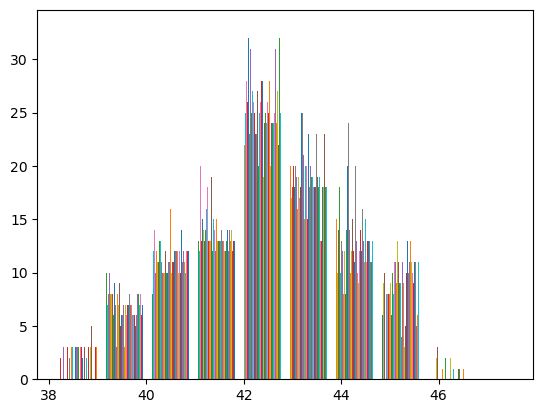

In [35]:
plt.hist(sample)

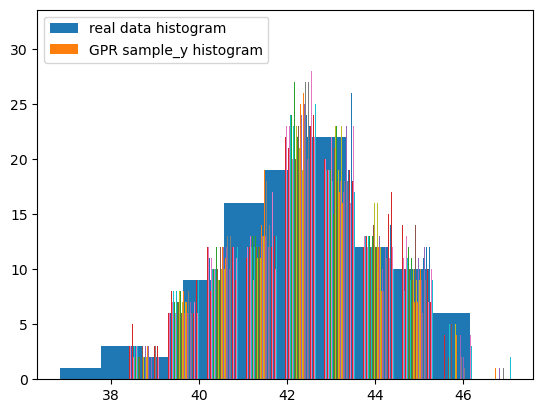

In [43]:
sample = gaussian_process.sample_y(z_sample[:, None], n_samples=100)
plt.hist(mu_sample, label = 'real data histogram')
plt.hist(sample, label = 'GPR sample_y histogram')
plt.legend()
plt.show()

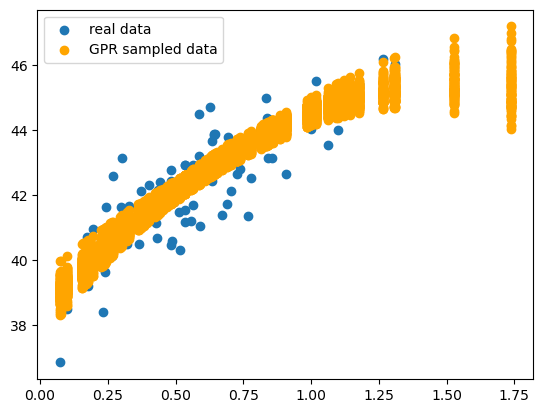

In [61]:
plt.scatter(z_sample, mu_sample, label = 'real data')
sample = gaussian_process.sample_y(z_sample[:, None], n_samples=100)
for i in range(100):
    if i == 0:
        plt.scatter(z_sample[:, None], sample[:, i], label = 'GPR sampled data', color = 'orange')
    else:
        plt.scatter(z_sample[:, None], sample[:, i], color = 'orange')
plt.legend()